In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
import scipy.constants as c
from slab.dsfit import*
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
from qutip import*

Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\Tantalum\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick


This is a calculator for the properties of 3D circuit QED systems with transmon qubits from HFSS simulations. We use both the Blackbox quantization metod based on [S. Nigg, et. al., Phys. Rev. Lett. 108, 240502 2012](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.240502)
as well as the Energy participation method described in [Zlatko Minev's thesis](https://arxiv.org/pdf/1902.10355.pdf).

# Black box quantization

In the Black box method, we calculate the admittance of the qubit cavity system, which is given by:
$$ Y(\omega) = j\omega C_J +\frac{1}{j\omega L_J}+Y_c(\omega)\text{ ,} $$
where $j=-i$ is the imaginary unit, $C_J$ is the junction self-capacitance, $L_J$ is the junction inductance, and $Y_c(\omega)$ is the admittance of the system sans the junction. To find $Y_c(\omega)$, we use HFSS, as shown in the [Supplemental material](http://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.108.240502/suppl_mat4.pdf) of the above article. For the correct format data for this calculator, we need an array consisting of 3 vectors: frequency and the real and imaginary parts of the admittance as a function of frequency. After performing a Driven Modal simulation over the frequency range, go to Results (right click) $\rightarrow$ Create Modal Solution Data Report $\rightarrow$ Data Table. Then, create a table with the real and imaginary parts of the admittance $Y(1,1)$. Right click anywhere on the table and Export the data as a .csv file.


In [2]:
fname = r"S:\Vatsan\3D Multimode\3D MM multimode flute and 3D readout new\data\imY11_1_t_430um_L_2850_qoffset_1985_L_23000_q_assym2_850.csv"
data_raw = transpose(genfromtxt(fname,skip_header=1,delimiter=",",dtype=float))
print (shape(data_raw))

data = array([data_raw[0],zeros(len(data_raw[0]))])
for i,x in enumerate(data_raw[1:].T):
    for y in x:
        if not isnan(y):
            data[1][i] = y
            
fname = r"S:\Vatsan\3D Multimode\3D MM multimode flute and 3D readout new\data\reY11_1_t_430um_L_2850_qoffset_1985_L_23000_q_assym2_850.csv"
data_raw2 = transpose(genfromtxt(fname,skip_header=1,delimiter=",",dtype=float))
print (shape(data_raw2))

data2 = array([data_raw2[0],zeros(len(data_raw2[0]))])
for i,x in enumerate(data_raw2[1:].T):
    for y in x:
        if not isnan(y):
            data2[1][i] = y

(17, 319985)
(17, 319985)


In [3]:
freqs = array(data[0])*1e9 #HFSS gives frequency in GHz
Y_imag = array(data[1])
Y_real = array(data2[1])
Y_c = Y_real + 1j*Y_imag
# L_J = 8e-9 #Henries

L_J = 6.5e-9 #Henries
# L_J = 6.5e-9 #Henries
E_J = (c.h/(2*c.e))**2/(4*L_J*c.pi**2)
print ("Josephson Energy =",E_J/c.h/1e9,"GHz")
C_J = 4.0e-15 #Farads
E_CJ = c.e**2/(2*C_J)
Y_J = 1.0j*2.0*c.pi*freqs*C_J - 1.0j/(2.0*c.pi*freqs*L_J)
Y_imag += imag(Y_J)

Josephson Energy = 25.147925047197106 GHz


## Black box Linearization

![](http://journals.aps.org/prl/article/10.1103/PhysRevLett.108.240502/figures/2/large)

Caption quoted from paper: "(a) Schematics of a JJ ((red) boxed cross) coupled to an arbitrary linear circuit (striped disk). (b) The Josephson element is replaced by a parallel combination of: a linear inductance $L_J$, a linear capacitance $C_J$ and a purely nonlinear element with energy $E_J[1−cos(\varphi)]−(E_J/2)\varphi^2$, represented by the spider symbol. (c) The linear part of the circuit shown in (b) is lumped into an impedance $Z(\omega)$ seen by the nonlinear element. (d) Foster-equivalent circuit (pole-decomposition) of the impedance $Z(\omega)$."

In the black-box calculation, the circuit is treated as a linear $RLC$ circuit, with the non-linearity of the junction reintroduced as a perturbation. After partitioning the Josephson junction into its linear and nonlinear components (b), we group the linear elements of the circuit together to and calculate the effective impedence between the blue nodes in (c). Finally, Foster's Thereom allows us to calculate the impedence as the sum of the effective lumped impedences of the modes $p$ of the circuit:
$$ Z(\omega) = \sum_{p=1}^M \left( j\omega C_p + \frac{1}{j\omega L_p} + \frac{1}{R_p} \right)^{-1} $$

Since it is easier in general to work with zeroes instead of poles, we use the admittance, $Y(\omega) = Z(\omega)^{-1}$, for convenience in our calculations.

The resonance frequencies of the linear circuit are given by the real parts of the poles of the impedence, or conversely the zeroes of the admittance, while the imaginary parts give the width of the poles or, effectively, the decay rate. 

Mode Frequencies: [5.03649682 5.71567078 5.97063853 6.21465573 6.46215311 6.71437572
 6.97100855 7.2280014  7.47714886 7.7340392  7.93772439 7.98843942
 8.24822741 8.50082504 8.76461323 9.02253613 9.28387919 9.55161258
 9.82234612] GHz


C:\Users\Tantalum\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


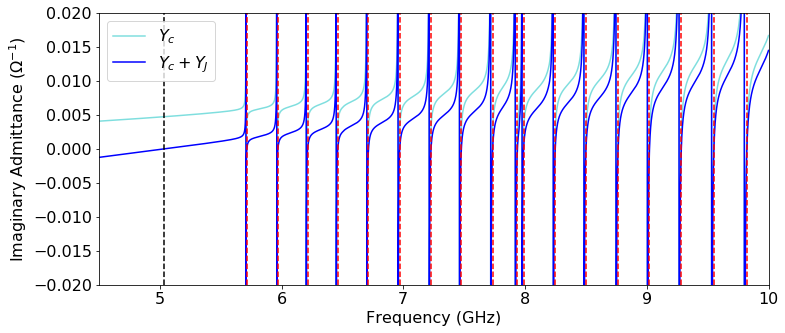

In [4]:
figure(figsize=(12,5))
subplot(111,xlabel = 'Frequency (GHz)',ylabel = 'Imaginary Admittance ($\Omega^{-1}$)')
plot(freqs/1e9,imag(Y_c),color='c',label = '$Y_c$',alpha = 0.5)
plot(freqs/1e9,Y_imag,color='b',label = '$Y_c + Y_J$')
legend()
def find_roots_monotonic(X_array,Y_array):
    roots = array([])
    for i,x in enumerate(X_array):
        if i == 0:
            pass
        elif (Y_array[i]>0.0 and Y_array[i-1]<0.0):
            roots = append(roots,x)
        else:
            pass
    return roots
f_p = find_roots_monotonic(freqs,Y_imag)

for ii,f in enumerate(f_p):
    if ii is 0:axvline(f/1e9,ls='dashed',color='k')
    else:axvline(f/1e9,ls='dashed',color='r')

ylim(-0.02,0.02)
xlim(min(freqs/1e9),max(freqs/1e9))

print ('Mode Frequencies: %s GHz' %(f_p/1e9))
# axvline(7.85,color='k')
# axvline(8.14,color='k')


Mode Frequencies: [5.03649682 5.71567078 5.97063853 6.21465573 6.46215311 6.71437572
 6.97100855 7.2280014  7.47714886 7.7340392  7.93772439 7.98843942
 8.24822741 8.50082504 8.76461323 9.02253613 9.28387919 9.55161258
 9.82234612] GHz


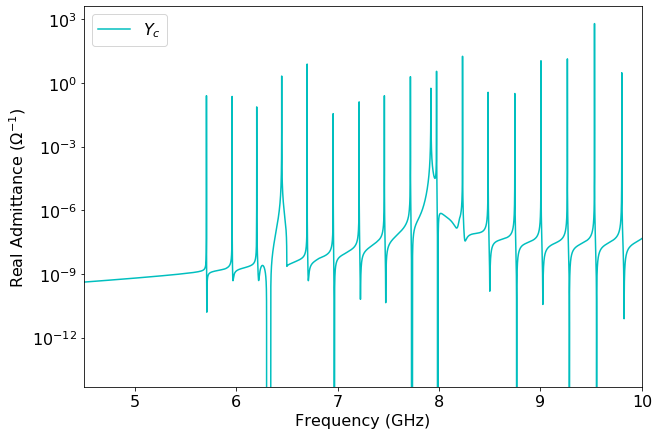

In [5]:
figure(figsize=(10,7))
subplot(111,xlabel = 'Frequency (GHz)',ylabel = 'Real Admittance ($\Omega^{-1}$)')

semilogy(freqs/1e9,real(Y_c),color='c',label = '$Y_c$')


xlim(min(freqs/1e9),max(freqs/1e9))

print ('Mode Frequencies: %s GHz' %(f_p/1e9))
# axvline(7.85,color='k')
# axvline(8.14,color='k')
legend(loc=2)

Mode Frequencies: [5.03649682 5.71567078 5.97063853 6.21465573 6.46215311 6.71437572
 6.97100855 7.2280014  7.47714886 7.7340392  7.93772439 7.98843942
 8.24822741 8.50082504 8.76461323 9.02253613 9.28387919 9.55161258
 9.82234612] GHz


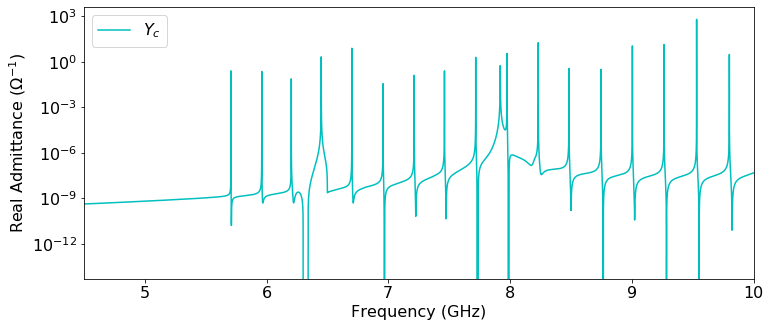

In [6]:
figure(figsize=(12,5))
subplot(111,xlabel = 'Frequency (GHz)',ylabel = 'Real Admittance ($\Omega^{-1}$)')

semilogy(freqs/1e9,real(Y_c),color='c',label = '$Y_c$')


xlim(min(freqs/1e9),max(freqs/1e9))

print ('Mode Frequencies: %s GHz' %(f_p/1e9))
# axvline(7.85,color='k')
# axvline(8.14,color='k')
legend(loc=2)

### The effective resistance, capacitance, and inductance for the lumped elements of the model circuit in (d) can be calculated from the admittance as follows:
$$\omega_p = \frac{1}{\sqrt{L_p C_p}},  R_p = \frac{1}{\text{ Re }Y(\omega_p)}, \text{ } C_p = \tfrac{1}{2}\text{ Im }Y'(\omega_p), \text{ } L_p = \frac{1}{2\omega_p^2 \text{ Im }Y'(\omega_p)}$$
These elements become useful for future calculations.

In [9]:
dY_imag = zeros(len(Y_imag)) 
fstep = 2*c.pi*(freqs[1] - freqs[0])
for i,y in enumerate(Y_imag):
    if i==0:
        dY_imag[i] = (Y_imag[i+1]-y)/(2*c.pi*(freqs[i+1] - freqs[i]))
    elif i==(len(Y_imag)-1):
        dY_imag[i] = (y-Y_imag[i-1])/(2*c.pi*(freqs[i] - freqs[i-1]))
    else:
        dY_imag[i] = ((Y_imag[i+1]-y)/(2*c.pi*(freqs[i+1] - freqs[i]))+(y-Y_imag[i-1])/(2*c.pi*(freqs[i] - freqs[i-1])))/2.0

R_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            R_p = append(R_p,1.0/(Y_real[i]))
        else:
            pass

C_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            C_p = append(C_p,dY_imag[i]/2.0)
        else:
            pass

L_p = array([])
for f in f_p:
    for i,x in enumerate(freqs):
        if f==x:
            L_p = append(L_p,2.0/((2*pi*x)**2*dY_imag[i]))
        else:
            pass

Z_p = sqrt(L_p/C_p)

Gq = 4*pi*c.e**2/c.h
 
Phi_p = sqrt(Gq*Z_p) 
        
print ('Mode resistances: %s Ohms' %R_p)
print ('Mode capacitances: %s F' %C_p)
print ('Mode inducatances: %s H' %L_p)
print ('Mode impedences: %s Ohm' %Z_p)
print ('Dimensionless mode phase fluctuation: %s ' %Phi_p)


Q_p = array([])
for f,R,C in zip(f_p,R_p,C_p):
    Q_p = append(Q_p,2*c.pi*f*R*C)
print ('Mode Q\'s: %s' %Q_p)



Mode resistances: [ 1.53111426e+09  2.21695342e+09  1.94177650e+09  4.83603102e+08
  2.52079324e+05  1.70827008e+09  7.94247919e+09  2.56765035e+09
  1.20087934e+09 -4.09211016e+07  1.04447040e+04 -4.62898448e+06
  1.46913840e+07  6.28123596e+09 -3.80873879e+10  6.88676956e+09
  1.05897791e+10  5.67938444e+09  3.95733576e+09] Ohms
Mode capacitances: [1.83653071e-13 1.68290724e-11 1.78986044e-11 1.89651396e-11
 1.98965936e-11 2.17012295e-11 2.48536225e-11 2.56827006e-11
 2.75656528e-11 3.13567755e-11 2.93378202e-11 2.90200640e-11
 3.32010162e-11 3.48377221e-11 3.76614414e-11 4.10280883e-11
 4.22145187e-11 4.56358988e-11 4.53060429e-11] F
Mode inducatances: [5.43732057e-09 4.60729132e-11 3.96989970e-11 3.45819969e-11
 3.04864633e-11 2.58907508e-11 2.09729410e-11 1.88783102e-11
 1.64361436e-11 1.35050479e-11 1.37031493e-11 1.36778553e-11
 1.12141829e-11 1.00616303e-11 8.75543672e-12 7.58405933e-12
 6.96176662e-12 6.08387465e-12 5.79500299e-12] H
Mode impedences: [172.06532995   1.65459896

In [14]:
# L_p
EL_p = (c.h/(2*c.e))**2/(4*L_p*c.pi**2)/c.h/1e9
# print ("Josephson Energy =",E_J/c.h/1e9,"GHz")
print (EL_p)

[   30.06287944  3547.88749895  4117.52248726  4726.78061623
  5361.77355038  6313.50994567  7793.92422791  8658.69407134
  9945.24729592 12103.73441232 11928.75515456 11950.8145929
 14576.31952836 16246.02650406 18669.71551048 21553.30089354
 23479.88976227 26867.99486873 28207.32155623]


In [18]:
# C_p
E_Cp = c.e**2/(2*C_p)/c.h/1e9

print (E_Cp)

[0.10547185 0.001151   0.00108222 0.00102136 0.00097355 0.00089259
 0.00077937 0.00075421 0.00070269 0.00061774 0.00066025 0.00066748
 0.00058342 0.00055601 0.00051433 0.00047212 0.00045885 0.00042445
 0.00042754]


For a parallel resonant circuit (as shown in (d)), the quality factor of mode $p$ is given by $Q_p = \omega_p R_p C_p$. Thus, the qualtiy factor for mode $p$ is:

In [8]:
Q_p = array([])
for f,R,C in zip(f_p,R_p,C_p):
    Q_p = append(Q_p,2*c.pi*f*R*C)
print ('Mode Q\'s: %s' %Q_p)

Mode Q's: [ 8.89844723e+06  1.33987357e+09  1.30382426e+09  3.58131124e+08
  2.03644679e+05  1.56396267e+09  8.64612017e+09  2.99484719e+09
  1.55519035e+09 -6.23540907e+07  1.52826920e+04 -6.74257684e+06
  2.52786911e+07  1.16878816e+10 -7.89933897e+10  1.60178909e+10
  2.60770280e+10  1.55548004e+10  1.10650692e+10]


## Quantization

Neglecting dissipation, the Hamiltonian of the linear circuit is simply a sum of the electric and magnetic energies across each resonator:

$$ H_0 = \sum_{p} \frac{Q_p^2}{2C_p} + \frac{\Phi_p^2}{2L_p} = \sum_{p} 4E^{C}_{p}N_p^2 + \frac{E^{L}_{p}}{2}\varphi_p^2 =  \hbar \omega_p \left(a_p^\dagger a_p + \frac{1}{2}\right)$$

where we introduce generalized coordinates, flux $\phi_p$ and charge $q_p$, for each mode $p$ of the resonator. From canonical quantization, it follows that:

$$ \Phi_p = \sqrt{\frac{\hbar}{2}\sqrt{\frac{L_p}{C_p}}}\left(a_p+a_p^\dagger\right), \text{  } Q_p = j\sqrt{\frac{\hbar}{2}\sqrt{\frac{C_p}{L_p}}}\left(a_p-a_p^\dagger\right) $$.

We may rewrite above instead in terms of the phase $\varphi$  across the josephson junction, and the number $N_p$ of Cooper pairs.  The phase is related to the flux across the junction as $\varphi = \frac{\phi}{\phi_0}$, where $\phi=\frac{h}{2e}$ is the flux quantum. From above, we see that the phase across the junction is:

### Simple formula for computing zero point phase fluctuations

$$ \varphi = \frac{1}{\phi_0}\sum_p \sqrt{\frac{\hbar}{2}\sqrt{\frac{L_p}{C_p}}}\left(a_p+a_p^\dagger\right) $$


One may also compute the zero point phase fluctuations by simply using virial theorem 

$$ \frac{E^{L}_{p}}{2}\left<\varphi_p^2\right> = \frac{\hbar\omega_p}{4}  \Rightarrow \left<\varphi_p^2\right> = \sqrt{\frac{2E^C_p}{E^J_p}} = 2\pi\left(\frac{2 e^2}{h}\right)\sqrt{\frac{L_p}{C_p}} = 2\pi G_Q Z_{p} $$

where $G_Q = \frac{2e^2}{h}$ is the conductance quantum and $Z_p = \sqrt{L_p/C_p}$is the impedance of a mode. In the absence of the coupling to other modes, this is just the fluctuation in the phase across the junction. The coupling between the transmon and the resonator modes results in participation  of the modes in the junction phase. Rewriting the phase of the junction in terms of the new normal modes gives:

$$ \hat{\varphi} = \sum_p\sqrt{2\pi G_Q Z_{p}}\left(a_p+a_p^\dagger\right) $$


### Mapping to a multimode Jaynes Cummings model 

Mapping to a multimode jaynes cummings model of a qubit like mode coupled to many cavity modes

$$\hat{H} = \hbar\omega_qc^{\dagger}c + \frac{\alpha}{2}c^{\dagger}c\left(c^{\dagger}c - 1\right) + \sum_{m}\hbar\omega_m b_m^{\dagger}b_{m} + g_m (b^{\dagger}_{m}c + b_{m}c^{\dagger} )$$


This hamiltonian can be diagonalized to lowest order using a dispersive transformation


$$ \hat{O} \rightarrow e^{S}\hat{O}e^{-S}, S = \sum_{m}\frac{g_{m}}{\Delta_{m}}\left(b^{\dagger}_{m}c - b_{m}c^{\dagger} \right) $$


$$ \Rightarrow \hat{\varphi} = \phi_q\left[\left(\hat{c} + \hat{c}^{\dagger}\right) + \sum_m\frac{g_{m}}{\Delta_m}\left(b^{\dagger}_{m} + b_{m}^{\dagger}\right)\right] $$

Comparing with relation for the dressing from the dispersive transformation and the expression for the junction phase obtained from black box quantization/diagonalization:

\begin{equation}
\frac{g_m}{\Delta_m} = \sqrt{\frac{Z_m}{Z_q}} \Rightarrow \chi_m = -2\frac{g_m^2 \alpha }{\Delta_m\left(\Delta_m + \alpha\right)} \approx -2E_c\sqrt{\frac{L_m}{L_q}\frac{C_q}{C_m}}
\end{equation}

$\textbf{Note the convention for the definition of $\chi$}$, $$ H_{disp} = \chi_{pq}a_p^\dagger a_p\left|e\right>\left<e\right|$$


## Reintroduce Non-linearity

The previously excluded nonlinear element of the circuit Hamiltonian is given by:
$$ H_{nl} = E_J(1-\cos{(\varphi)}) - \tfrac{1}{2}E_J \varphi^2 = E_J\left(-\frac{\varphi^4}{4!} + \mathcal{O}\left({\varphi^6}\right)\right)$$

Rewriting the above in terms of the normal modes of the linearized system

\begin{eqnarray}
 H_{nl} =  -E_J\frac{\varphi^4}{4!} &=& -\left(\frac{E_J}{24}\right)\left(\sum_p\sqrt{2\pi G_Q Z_{p}}\left(a_p+a_p^\dagger\right)\right)^4 \\
 &=& -\left(\frac{E_{CJ}}{12}\right)\left(\sum_p\sqrt{\frac{ Z_{p}}{Z_J}}\left(a_p+a_p^\dagger\right)\right)^4\\
 &=& -\left(\frac{E_{C}}{12}\right)\left(\sum_p\sqrt{\frac{ Z_{p}}{Z_q}}\left(a_p+a_p^\dagger\right)\right)^4
 \end{eqnarray}

Plugging this into the nonlinear Hamiltonian and simplifying:
$$ H_{nl} = \sum_p \hbar\Delta_p n_p + \frac{1}{2} \sum_{p,p'} \hbar \chi_{pp'} n_p n_{p'} $$
where $n_p = a_p^\dagger a_p$ is the number operator for mode $p$. The first term in the nonlinear Hamiltonian is a correction $\Delta_p$ to the mode frequencies calculated in the linear case:
$$\Delta_p = \frac{-e^2}{2\hbar L_J}\left(\sqrt{\frac{L_p}{C_p}}\sum_q\sqrt{\frac{L_q}{C_q}} - \frac{L_p}{2C_p}\right) $$

In [7]:
delta_p = array([])
for L,C in zip(L_p,C_p):
    d = -c.e**2/(2*L_J)*(sum(sqrt(L/C)*sqrt(L_p/C_p)) - L/(2*C))/c.h
    delta_p = append(delta_p,d)
print ('Mode frequency correction: %s MHz' %(delta_p/1e6))

Mode frequency correction: [-51.57909287  -0.91611767  -0.82495802  -0.74827453  -0.68613485
  -0.605683    -0.50962726  -0.475719    -0.42855289  -0.36433936
  -0.37939215  -0.38110819  -0.32271517  -0.29844998  -0.267804
  -0.23883484  -0.22560257  -0.20286157  -0.19871033] MHz


The second term in the expansion is the generalized $\chi$-shift between modes $p$ and $p'$. When $p=p'$, you get the self-Kerr shift of mode $p$:
$$ \chi_{pp} = -E_{C_J}\left(\frac{Z_p}{Z_J}\right)^{2} = -\frac{L_p}{L_J}\frac{C_J}{C_p} E_{C_J} $$. 
This is can be written more transparently as:

$$ \chi_{pp} = -E_{C}\left(\frac{Z_p}{Z_q}\right)^{2} = -\frac{L_p}{L_q}\frac{C_q}{C_p} E_{C} $$. 

This readily gives that the anharmonicity of the qubit $\chi_{qq} = \alpha = - E_C$.When $p\neq p'$, you get the cross-Kerr shift of mode $p$ due to mode $p'$:

$$ \chi_{pp'} = -2\sqrt{\chi_{pp}\chi_{p'p'}} $$

From this, we can construct the Kerr matrix for our system. We see that the dispersive shift of each mode is,

$$ \chi_{qp} = -2E_{C}\left(\frac{Z_p}{Z_q}\right)  $$

In [8]:
chi_pp = zeros([len(f_p),len(f_p)])
for i,(L,C) in enumerate(zip(L_p,C_p)):
    chi_pp[i][i] = -L/L_J*C_J/C*E_CJ/c.h
for i,(L,C) in enumerate(zip(L_p,C_p)):
    for j in range(len(f_p)):
        if j==i:
            pass
        else:
            chi_pp[i][j] = -2*sqrt(chi_pp[i][i]*chi_pp[j][j])
# print ('Kerr shifts: \n %s MHz' %(chi_pp/1e6))

From these Kerr shifts, you can extract a wealth of information. First, the self-Kerr shift $\chi_pp$ of each mode $p$ is equivalent to its anharmonicity, $\alpha_p$. Thus, the mode with the largest anharmonicity is the most "Qubit-like" mode (all the eigenmodes of the circuit and superpositions of qubit and cavity states).

In [9]:
alpha_p = diag(chi_pp)
print ('Anharmonicity: %s MHz' %(alpha_p/1e6))
qubit_index = argmax(abs(alpha_p))
print ('Qubit Index: %s' %qubit_index)

Anharmonicity: [-8.82283483e+01 -8.15843583e-03 -6.60970033e-03 -5.43394739e-03
 -4.56614524e-03 -3.55534469e-03 -2.51472815e-03 -2.19050292e-03
 -1.77685934e-03 -1.28347123e-03 -1.39191896e-03 -1.40456242e-03
 -1.00655535e-03 -8.60676631e-04 -6.92791072e-04 -5.50860771e-04
 -4.91449643e-04 -3.97278493e-04 -3.81170199e-04] MHz
Qubit Index: 0


From the cross-Kerr shift, you can estimate the effective resonant vacuum Rabi rate, $g_p$, between the qubit and mode $p$: 
$$ g_p = \sqrt{\chi_{qp} \Delta_{qp} \frac{\Delta_{qp} + \alpha_q}{\alpha_q}} $$

In [10]:
g_p = array([])
g_p2 = array([])
chi_p = array([])
for i,f in enumerate(f_p):
    d = f_p[qubit_index]-f
    a = alpha_p[qubit_index]
    x = chi_pp[qubit_index][i]/2.0
    print (x/1e6)
    print (a/1e6)
    g = sqrt(x*d*(d+a)/a)
    g_p = append(g_p,g)
    g_p2 = append(g_p2,d*Phi_p[i]/Phi_p[qubit_index])
    chi_p = append(chi_p,x)
print ('g (from xi): %s MHz' %(g_p/1e6))
print ('g (from g_k/delta_k = Phi_k/Phi_q): %s MHz' %(abs(g_p2)/1e6))


-44.114174150529564
-88.22834830105913
-0.8484134120806992
-88.22834830105913
-0.7636510607697453
-88.22834830105913
-0.6924075411758726
-88.22834830105913
-0.6347152531727396
-88.22834830105913
-0.5600733786061913
-88.22834830105913
-0.4710311144002917
-88.22834830105913
-0.43961853254286754
-88.22834830105913
-0.39594111323950504
-88.22834830105913
-0.336509355786935
-88.22834830105913
-0.35043788487908384
-88.22834830105913
-0.35202588349681846
-88.22834830105913
-0.2980045575838966
-88.22834830105913
-0.27556501517343684
-88.22834830105913
-0.247232303655602
-88.22834830105913
-0.22045756053865762
-88.22834830105913
-0.20823013787248235
-88.22834830105913
-0.18721972451694108
-88.22834830105913
-0.18338488779075535
-88.22834830105913
g (from xi): [ -0.          70.79486391  90.9188318  108.20866063 124.60607013
 137.15360647 144.53613792 157.77823668 166.42873106 169.2978022
 185.60446699 189.22834028 189.2043862  196.05954116 199.67195287
 201.44383942 208.4747873  210.01141008 22

In [11]:
print (Phi_p[i])

0.013195069872435287


## Summary

In [12]:
qi = qubit_index
print ('-----Qubit Properties-----')
print ('Index: %s' %qi)
print ('Frequency: %s GHz' %around((f_p[qi]+delta_p[qi]+alpha_p[qi])/1e9,decimals=3))
print ('Anharmonicity: %s MHz' %around((alpha_p[qi])/1e6,decimals=3))
print ('E_J: %s GHz' %around(E_J/c.h/1e9,decimals=3))
print ('E_C: %s MHz' %around(c.e**2/(2*C_p[qi])/c.h/1e6, decimals=3))
print ('E_J/E_C: %s' %around(E_J/(c.e**2/(2*C_p[qi])),decimals=3))
print ('Purcell limit Q: %s' %Q_p[qi])
print ('Purcell limit T1: %s us' %around(Q_p[qi]/(2*c.pi*f_p[qi])*1e6,decimals=1))
ej = around(E_J/c.h/1e9,decimals=3)
ec = c.e**2/(2*C_p[qi])/c.h/1e9



nu_q = around((f_p[qi]+delta_p[qi]+alpha_p[qi])/1e9,decimals=3)
Ej = around(E_J/c.h/1e9,decimals=3)
Ec = around(c.e**2/(2*C_p[qi])/c.h/1e9, decimals=3)

for i,(f,d,a,q,x,g) in enumerate(zip(f_p,delta_p,alpha_p,Q_p,chi_p,g_p)):
    if i==qi:
        continue
    print ('\n-----Mode %s Properties-----' %i)
    print ('Frequency: %s GHz' %around((f+d+a)/1e9,decimals=3))
    print ('Q: %s' %q)
    print ('T1: %s us' %around(q/(2*c.pi*f)*1e6,decimals=3))
    print ('Chi to qubit: %s MHz' %around(x/1e6,decimals=3))
    print ('g to qubit: %s MHz' %around(g/1e6,decimals=3))
    print ('Self-Kerr shift: %s kHz' %around(a/1e3,decimals=3))
    
    
purc = array([(2*pi*f/q)*(g**2/(f-f_p[0])**2) for i,(f,d,a,q,x,g) in enumerate(zip(f_p,delta_p,alpha_p,Q_p,chi_pp[qi],g_p))]) 
gam = sum(purc[1:])
T1 = 1/gam
print ("Naive estimate of Purcell limit = %s mus "%(T1*1e6))

-----Qubit Properties-----
Index: 0
Frequency: 4.897 GHz
Anharmonicity: -88.228 MHz
E_J: 25.148 GHz
E_C: 105.472 MHz
E_J/E_C: 238.433
Purcell limit Q: 8898447.23403669
Purcell limit T1: 281.2 us

-----Mode 1 Properties-----
Frequency: 5.715 GHz
Q: 1339873569.99139
T1: 37309.27 us
Chi to qubit: -0.848 MHz
g to qubit: 70.795 MHz
Self-Kerr shift: -8.158 kHz

-----Mode 2 Properties-----
Frequency: 5.97 GHz
Q: 1303824264.9157333
T1: 34755.09 us
Chi to qubit: -0.764 MHz
g to qubit: 90.919 MHz
Self-Kerr shift: -6.61 kHz

-----Mode 3 Properties-----
Frequency: 6.214 GHz
Q: 358131124.44861823
T1: 9171.6 us
Chi to qubit: -0.692 MHz
g to qubit: 108.209 MHz
Self-Kerr shift: -5.434 kHz

-----Mode 4 Properties-----
Frequency: 6.461 GHz
Q: 203644.67926980142
T1: 5.016 us
Chi to qubit: -0.635 MHz
g to qubit: 124.606 MHz
Self-Kerr shift: -4.566 kHz

-----Mode 5 Properties-----
Frequency: 6.714 GHz
Q: 1563962665.9840326
T1: 37071.561 us
Chi to qubit: -0.56 MHz
g to qubit: 137.154 MHz
Self-Kerr shift: -3

C:\Users\Tantalum\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


Naive estimate of Purcell limit = 67.31774035812008 mus 


In [44]:
chi_exp = array([-0.0011962012807326266, -0.0008675577283625445, -0.0006679882283880331, -0.0005679036482351724,
                  -0.0004677354886000963, -0.0003717651314792725, -0.00035883244761213454, -0.0003126808728661901,
                  -0.00027136968208525854, -0.00027576338150714363])*1e3

nu_exp = array([5.460828876273256, 5.716666667384021, 5.965217875982685, 6.223194636516004, 6.469132802261203, 6.727514112934075,
      6.989430710480986,7.2470435829027195,7.509036487741198,7.775310740653364,
      8.012660922332195])

g_n = array([ 49.27081753,  62.19233178,  71.48518548,  82.38946179,
        88.70726841,  92.11096615, 103.80613912, 108.85055184,
       113.0161427 ])


In [45]:
g2s

array([ 30.39147284,  47.77836588,  62.92556207,  77.53606781,
        88.30387265,  95.87814871, 107.21069595, 115.35681671,
       119.10725608])

In [43]:
def gfromchi(chi,alpha,delta):
    return sqrt(chi*delta*(delta+alpha)/alpha)

alpha = -0.142
nu_q = 4.990289093243232

deltas = nu_exp[:9] - nu_q

chimm2 = -chimm[:9]
g2s = array([gfromchi(chimm2[ii]*1e-3,alpha,delta) for ii,delta in enumerate(deltas)])*1e3

Sum of the participation ratios:  0.9919954294234766
Qubit amplitude at the junction:  0.9563529880865665


C:\Users\Tantalum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


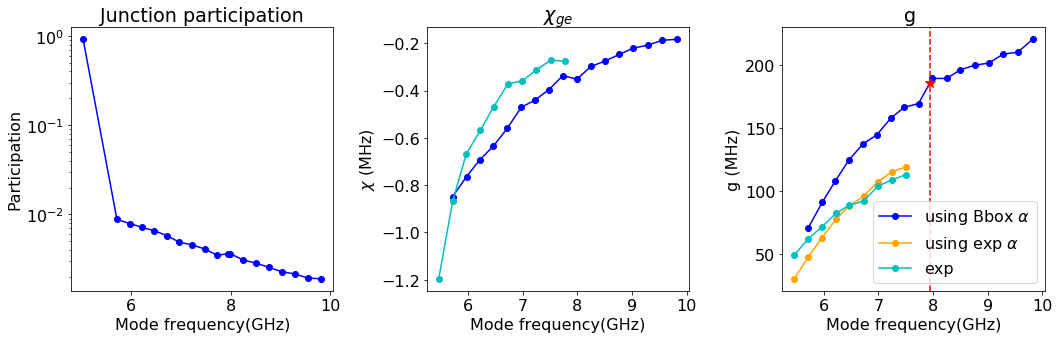

In [50]:
ri= argmin(abs(Q_p[:]))
alpha = -ec
eps = 2.0
nu_r = f_p[ri]/1e9

Phzpt_J = (2*ec/ej)**0.25
beta_p = abs(Phi_p/Phzpt_J)
fmm = delete(f_p,[qi,ri])/1e9
gmm = delete(g_p,[qi,ri])/1e6
chimm = -delete(chi_p,[qi,ri])/1e6
chir = abs(chi_p[ri])/1e6
beta_mm = delete(beta_p,[qi,ri])
beta_r = beta_p[ri]
g_r = g_p[ri]/1e6

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,3,3,title = 'g ')

ax.plot(fmm,gmm,'bo-',label = 'using Bbox $\\alpha$')
ax.plot(nu_exp[:len(g_n)],g2s,'o-',color='orange',label = 'using exp $\\alpha$')
ax.plot(nu_exp[:len(g_n)],g_n,'co-',label = 'exp')
ax.plot(nu_r,g_r,'r*',markersize=10)
ax.axvline(nu_r,color='r',linestyle='dashed')

ax.set_xlabel('Mode frequency(GHz)')
ax.set_ylabel('g (MHz)')
ax.legend()


subplot(1,3,1,title='Junction participation')

semilogy(f_p/1e9,beta_p**2,'bo-')

xlabel('Mode frequency(GHz)')
ylabel('Participation')


ax =fig.add_subplot(1,3,2,title="$\\chi_{ge}$")

ax.plot(fmm,-chimm,'bo-')
ax.plot(nu_exp[:len(chi_exp)],chi_exp,'co-')
ax.set_xlabel('Mode frequency(GHz)')
ax.set_ylabel('$\chi$ (MHz)')

print ("Sum of the participation ratios: ",sum(beta_p**2))
print ("Qubit amplitude at the junction: ",max(beta_p))
plt.tight_layout()

# Energy participation method

$\bullet$ Uses eigenmode to obtain the participation factor. The junction is replaced with a lumped inductance with the appropriate value.

$\bullet$ The linear system is diagonalized to extract the eigenmodes

\begin{eqnarray}
H_{lin} &=& \tfrac{1}{2}E_J \varphi^2 + H_{EM} = \sum_{m}\hbar\omega_ma_m^\dagger a_m
\end{eqnarray}
$\bullet$ We decompose the phase across the junction in terms of the fields for the eigenmodes
\begin{eqnarray}
\phi &=& \sum_{m}\phi_m(\hat{a}_{m} + \hat{a}_{m}^{\dagger})
\end{eqnarray}
The energy participation method calculates the contribution of each mode to the phase fluctuation
by calculating the fraction of the inductive energy stored in the junction (the participation factor).


In [28]:
from pyEPR import Project_Info, pyEPR_HFSS, pyEPR_Analysis

project_info = Project_Info('S://Vatsan//3D Multimode//3D MM multimode flute and 3D readout new//HFSS',
                            project_name = '3DMM2_EPR2', # Project file name (string). "None" will get the current active one.
                            design_name  = 'Eigenmode'             # Design name (string). "None" will get the current active one.
                            )
epr_hfss = pyEPR_HFSS(project_info)





Connecting to HFSS ...
	File path to HFSS project found.
	Opened HFSS-App.
	Opened HFSS desktop.
	Opened link to HFSS user project.
	Connected successfully.
	 :)	 :)	 :)	

Design "Eigenmode" info:
	# eigenmodes    20
	# variations    0


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'S:\\Vatsan\\pyEPR-master\\data\\3DMM2_EPR2\\Eigenmode'

In [17]:
# modelist,pjs = (epr_hfss.get_p_j_all(np.arange(15)))
fem_ser, Qem_ser = epr_hfss.get_freqs_bare_pd(variation=None)

com_error: (-2147352567, 'Exception occurred.', (0, None, None, None, 0, -2147024381), None)

In [23]:
modelist,pjs = (epr_hfss.get_p_j_all(np.arange(15)))
fem_ser, Qem_ser = epr_hfss.get_freqs_bare_pd(variation=None)

p_j_0 = 0.8910439278501963
p_j_1 = 0.0018106714374252196
p_j_2 = 0.0020534859711443853
p_j_3 = 0.0019515467980065011
p_j_4 = 0.001883183833547447
p_j_5 = 0.0016752783213518528
p_j_6 = 0.0015139659488662594
p_j_7 = 0.0014174296060296618
p_j_8 = 0.0012100139258009734
p_j_9 = 0.0011050347429981161
p_j_10 = 0.0011454972524080028
p_j_11 = 0.001054025254114194
p_j_12 = 0.0009119899453825038
p_j_13 = 0.0008140679673312116
p_j_14 = 0.0007700456162052265


Sum of the participation ratios:  0.9103601644708079


C:\Users\Tantalum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


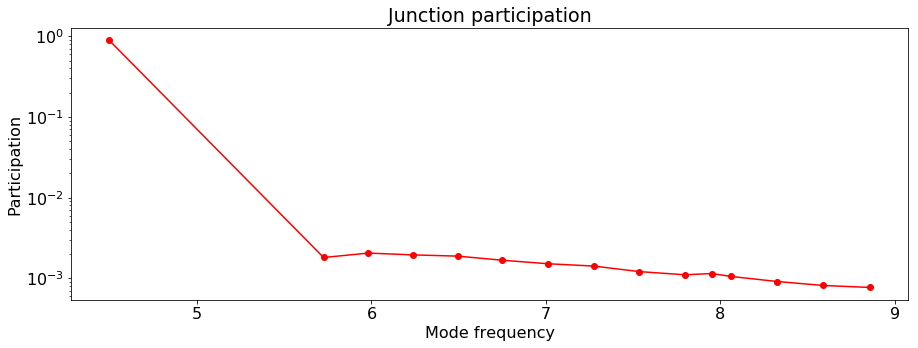

In [27]:
fig = plt.figure(figsize=(15,5))
subplot(111,title='Junction participation')

semilogy(fem_ser[:len(modelist)],pjs,'ro-')

xlabel('Mode frequency')
ylabel('Participation')

print ("Sum of the participation ratios: ",sum(pjs))


### g, Q and $\chi$ from 4th order expansion

Sum of the participation ratios:  0.9919954294234766
Qubit amplitude at the junction:  0.9563529880865665


C:\Users\Tantalum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


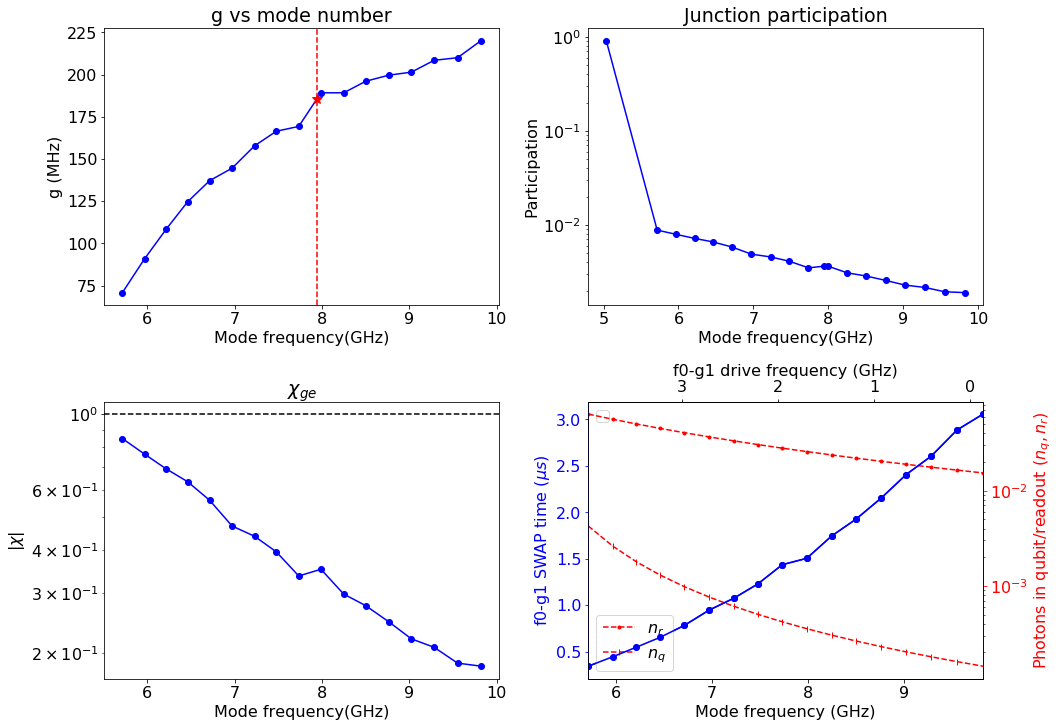

In [28]:
ri= argmin(abs(Q_p[:]))
alpha = -ec
eps = 2.0
nu_r = f_p[ri]/1e9

Phzpt_J = (2*ec/ej)**0.25
beta_p = abs(Phi_p/Phzpt_J)
fmm = delete(f_p,[qi,ri])/1e9
gmm = delete(g_p,[qi,ri])/1e6
chimm = -delete(chi_p,[qi,ri])/1e6
chir = abs(chi_p[ri])/1e6
beta_mm = delete(beta_p,[qi,ri])
beta_r = beta_p[ri]
g_r = g_p[ri]/1e6

def f0g1rate(f,chim,chir,eps):
    nud = 2*nu_q+alpha-f
    return nud,abs(sqrt(chim*chir)*eps/2*(1/(nud-nu_q) + 1/(nud-nu_r)))

def f0g1photonnumber_read_m(f,eps):
    nud = 2*nu_q + alpha-f
    return abs(eps/2*(1/(nud-nu_r)))**2

def f0g1photonnumber_coupler_m(f,eps):
    nud = 2*nu_q + alpha-f
    return abs((beta_r)*eps/2*(1/(nud-nu_q)))**2

f0g1 = array([f0g1rate(f,chimm[ii],chir,eps) for ii,f in enumerate(fmm)])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,2,1,title = 'g vs mode number')

ax.plot(fmm,gmm,'bo-')
ax.plot(nu_r,g_r,'r*',markersize=10)
ax.axvline(nu_r,color='r',linestyle='dashed')

ax.set_xlabel('Mode frequency(GHz)')
ax.set_ylabel('g (MHz)')

ax = fig.add_subplot(3,2,2)

ax.semilogy(delete(f_p,qi)/1e9,delete(Q_p,qi),'bo-')
ax.set_xlabel('Mode frequency(GHz)')
ax.set_ylabel('Q')

subplot(3,2,2,title='Junction participation')

semilogy(f_p/1e9,beta_p**2,'bo-')

xlabel('Mode frequency(GHz)')
ylabel('Participation')

print ("Sum of the participation ratios: ",sum(beta_p**2))
print ("Qubit amplitude at the junction: ",max(beta_p))


ax =fig.add_subplot(3,2,3,title="$\\chi_{ge}$")

ax.semilogy(fmm,chimm,'bo-')
ax.set_xlabel('Mode frequency(GHz)')
ax.set_ylabel('|$\chi$|')

ax.axhline(1,color='k',linestyle='dashed')

ax = fig.add_subplot(3,2,4)

ax.plot(fmm,1/(4*f0g1.T[1]),'bo-')
# ax.set_ylim(0.1,10)

ax.set_ylabel("f0-g1 SWAP time ($\\mu s$)",color='b')
ax.set_xlim(fmm[0],fmm[-1])
ax.tick_params(axis='y',colors='b')
ax.set_xlabel("Mode frequency (GHz)")
ax.legend(loc=2)
ax2 = ax.twinx()
ax2.semilogy(fmm,array([f0g1photonnumber_read_m(f,eps) for f in fmm]),'r.--',label = '$n_r$')
ax2.semilogy(fmm,array([f0g1photonnumber_coupler_m(f,eps) for f in fmm]),'r|--',label  = '$n_q$')
# # ax2.axhline(0.1,color='r',linestyle='dashed')
# # ax2.axvline(nu_m/2+nu_r/2-alpha/2,color='m',linestyle='dashed')
ax2.set_ylabel("$n_r = \\xi_r^{2}$,$n_q = (g_r^{2}/\\Delta_r^2)\\xi_q^{2}$",color='r')
ax2.set_ylabel("Photons in qubit/readout ($n_q,n_r$)",color='r')
ax2.tick_params(colors='r')
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')
ax2.legend(loc=3)

ax3 = ax.twiny()
ax3.plot(f0g1.T[0],1/(4*f0g1.T[1]),'bo-')
ax3.set_xlabel('f0-g1 drive frequency (GHz)')
ax3.set_xlim(f0g1.T[0][0],f0g1.T[0][-1])







plt.tight_layout()

In [ ]:

fig = plt.figure(figsize=(15,5))
subplot(111,title='Junction participation')

semilogy(arange(len(beta_p)),beta_p,'bo-')
semilogy(modelist,pjs,'ro-')
xlim(modelist[0],modelist[-1])

xlabel('Mode number')
ylabel('Participation')

print ("Sum of the participation ratios: ",sum(beta_p**2))
print ("Qubit amplitude at the junction: ",max(beta_p))
